- Anomaly Detection and Recommender Systems

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
from scipy import stats
import matplotlib.pyplot as plt
import sklearn

In [2]:
def load_mat(Path):    
    return sio.loadmat(Path)

def generate_df(data, X_key):
    return pd.DataFrame(data.get(X_key), columns=['X1', 'X2'])

In [3]:
data1 = load_mat('./data/ex8data1.mat')
data1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [4]:
df1 = generate_df(data1, 'X')

In [9]:
?sns.lmplot

sns.set()
fig1 = plt.figure(1, figsize=(10,8), dpi=250)
sns.lmplot('X1', 'X2', data=df1, fit_reg=False, markers='+', height=10)
plt.show()

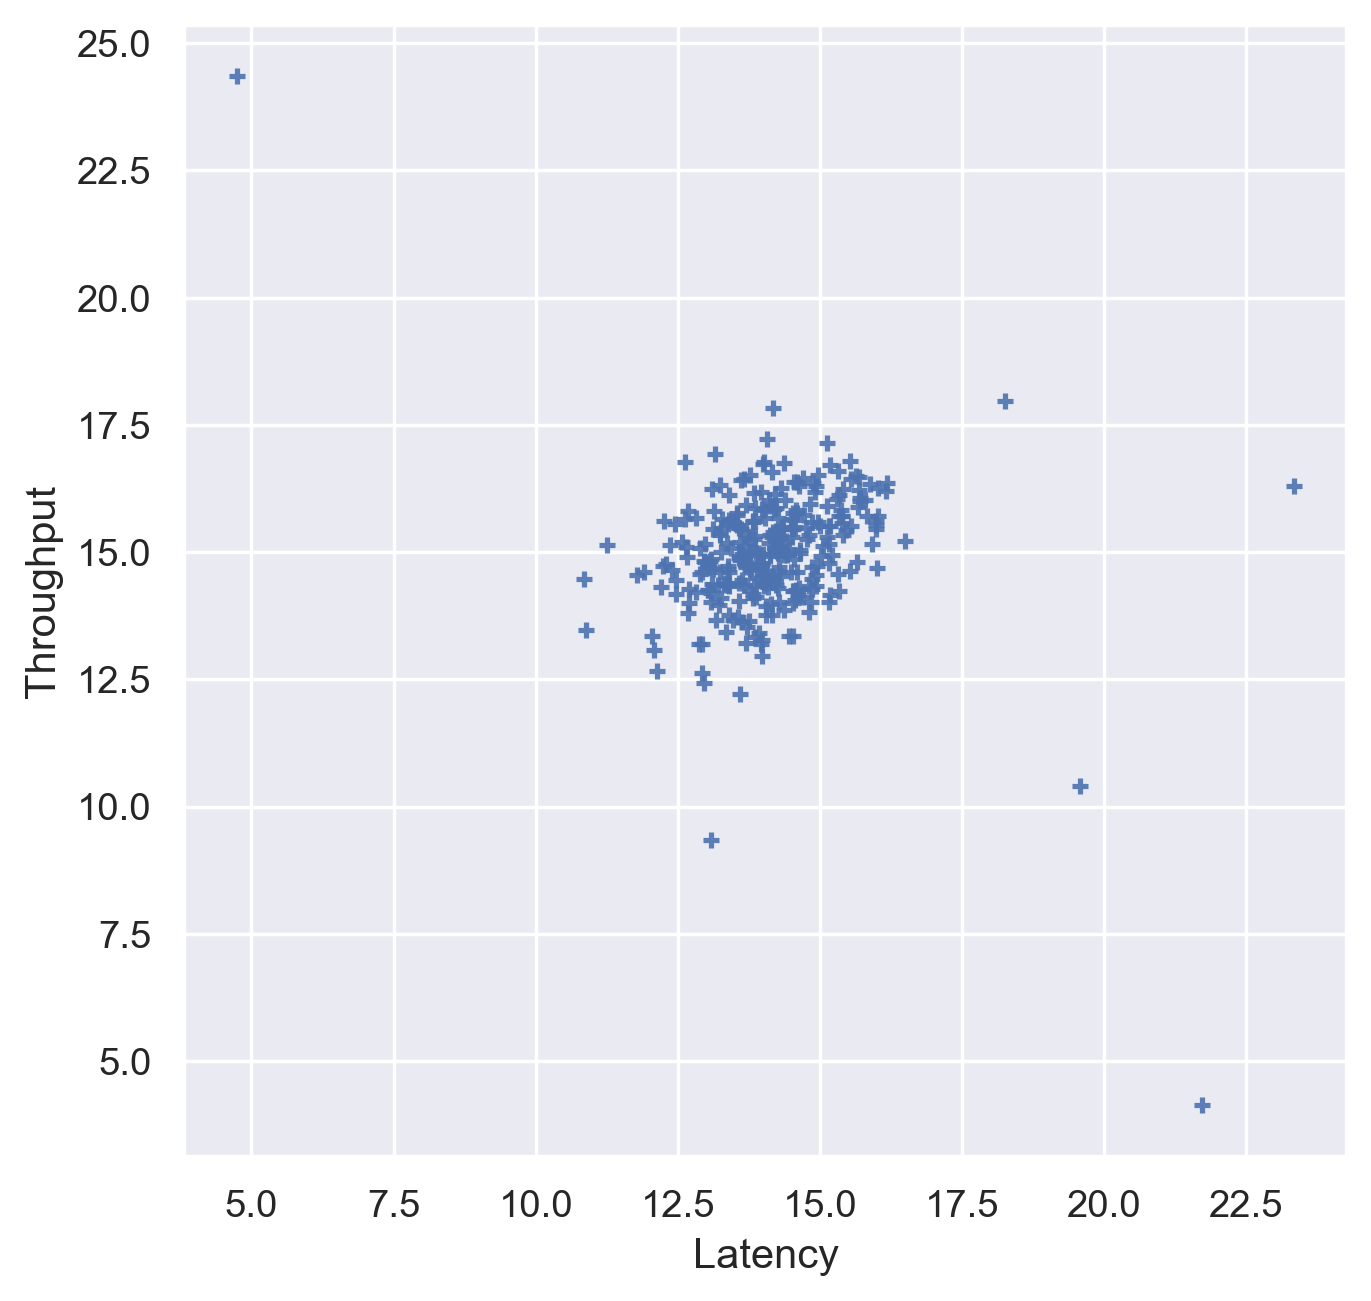

In [19]:
sns.set()
fig = plt.figure(1, figsize=(6,6), dpi=250)
sns.regplot('Latency', 'Throughput',
           data=pd.DataFrame(df1.values, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           scatter_kws={"s":20,
                        "alpha":0.9}, marker='+')
plt.show()

# Anomaly detection
## Gaussian distribution
$$p(x;\mu,\sigma^2)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

You can estimate the parameters, ($\mu_i, \sigma_i^2$), of the $i$-th feature by using the following equations. To estimate the mean, you will use:$$\mu_i=\frac{1}{m}\sum\limits_{j=1}^m x_i^{(j)}$$
and for the variance you will use: $$\sigma^2=\frac{1}{m}\sum\limits_{j=1}^m (x_i^{(j)}-\mu_i)^2$$

$$f(x) = \frac{1}{\sqrt{(2 \pi)^k \det \Sigma}}\exp\left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)$$

In [8]:
def multivariateGuassian(X, mu, Sigma2):
    """
    MULTIVARIATEGAUSSIAN Computes the probability density function of the
    multivariate gaussian distribution.
        p = MULTIVARIATEGAUSSIAN(X, mu, Sigma2) Computes the probability 
        density function of the examples X under the multivariate gaussian 
        distribution with parameters mu and Sigma2. If Sigma2 is a matrix, it is
        treated as the covariance matrix. If Sigma2 is a vector, it is treated
        as the \sigma^2 values of the variances in each dimension (a diagonal
        covariance matrix)
    """
    
    k = len(mu)
    
    matrixSigma2 = np.matrix(Sigma2)
    if matrixSigma2.shape[1] == 1 or matrixSigma2.shape[0] == 1 :
        diagSigma2 = np.diag(Sigma2)
    X_copy = X.copy()
    X_1 = X_copy - mu
#     print(X_1.shape)
    C = (2*np.pi)**(-k/2)*np.linalg.det(diagSigma2)**(-0.5)
#     print(C)
    index = (X_1.T*np.linalg.pinv(matrixSigma2).A*X_1.T).sum(axis=0)
#     print(index)
    p = C * np.exp(-0.5*index)
    
    return p.T

In [9]:
def estimateGuassian(X):
    mu = X.mean(axis=0)
#     sigma2 = ((df1 - mean)**2).sum(axis=0).values / df1.shape[0]
    cov = np.cov(X.T)
    
    return mu, cov

In [11]:
X = data1.get('X')

In [12]:
mu, cov = estimateGuassian(X)

## Visualization

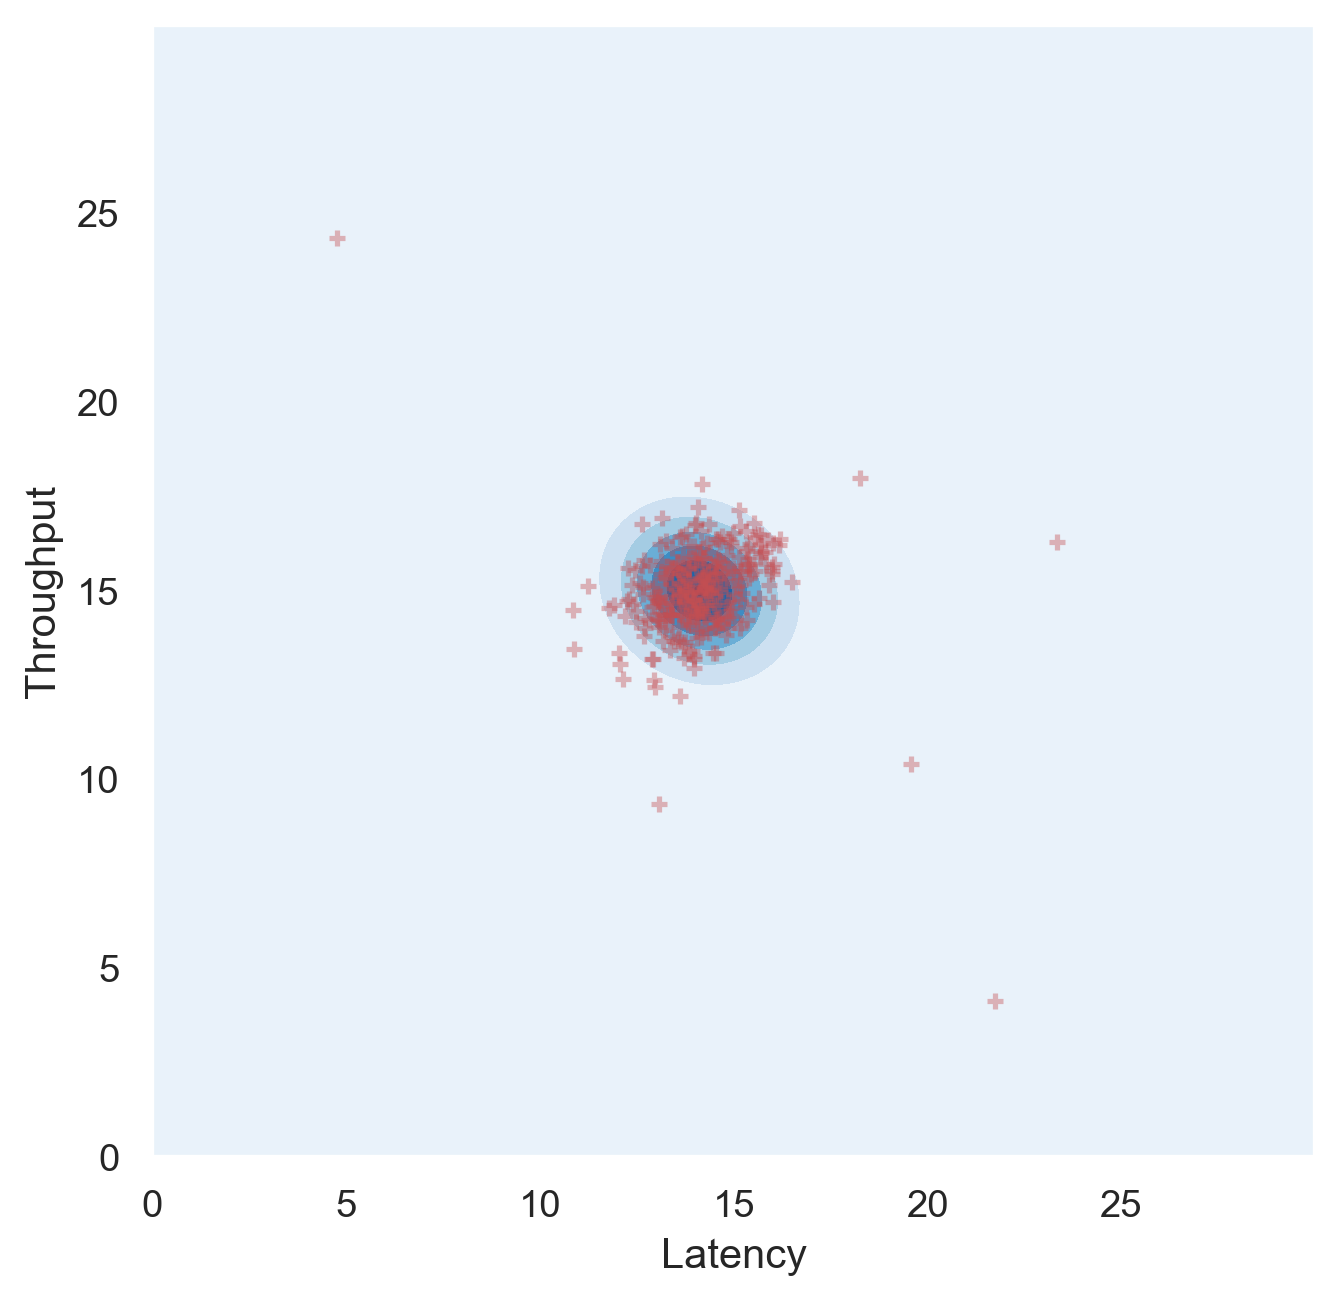

In [18]:
# create multi-var Gaussian model
multi_normal = stats.multivariate_normal(mu, cov)

# create a grid
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=250)

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original data points
sns.set()
sns.regplot('Latency', 'Throughput',
           data=pd.DataFrame(df1.values, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           ax=ax,
           scatter_kws={"s":20,
                        "alpha":0.4}, marker='+', color='r')
plt.show()

# Selecting threshold $\varepsilon$
1. use training set $X$ to model the multivariate Gaussian
2. use cross validation set $(X_{val}, y_{val})$ to find the best $\varepsilon$ based on the $F_1$ score

In [20]:
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

In [21]:
def selectThreshold(X, Xval, yval):
    """
    SELECTTHRESHOLD Find the best threshold (epsilon) to use for selecting
    outliers
       [bestEpsilon bestF1] = SELECTTHRESHOLD(yval, pval) finds the best
       threshold to use for selecting outliers based on the results from a
       validation set (pval) and the ground truth (yval).
    """
    # create multivariate model using training data
    mu, cov = estimateGuassian(X)
    multi_normal = stats.multivariate_normal(mu, cov)

    # this is key, use CV data for fine tuning hyper parameters
    pval = multi_normal.pdf(Xval)

    # set up epsilon candidates
    epsilon = np.linspace(np.min(pval), np.max(pval), num=10000)

    # calculate F1-score
    F1_score = []
    for e in epsilon:
        y_pred = (pval <= e).astype('int')
        F1_score.append(f1_score(yval, y_pred))

    # find the best f-score
    argmax_fs = np.argmax(F1_score)

    return epsilon[argmax_fs], F1_score[argmax_fs]

In [22]:
Xval, Xtest, yval, ytest = train_test_split(data1.get('Xval'),
                                            data1.get('yval').ravel(),
                                            test_size=0.5)

In [23]:
e, fs = selectThreshold(X, Xval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 3.6030764824313595e-05
Best F-score on validation data: 0.888888888888889


In [24]:
def predict(X, Xval, e, Xtest, ytest):
    """with optimal epsilon, combine X, Xval and predict Xtest
    Returns:
        multi_normal: multivariate normal model
        y_pred: prediction of test data
    """
    Xdata = np.concatenate((X, Xval), axis=0)

#     mu = Xdata.mean(axis=0)
#     cov = np.cov(Xdata.T)
    mu, cov = estimateGuassian(Xdata)
    multi_normal = stats.multivariate_normal(mu, cov)

    # calculate probability of test data
    pval = multi_normal.pdf(Xtest)
    y_pred = (pval <= e).astype('int')

    print(classification_report(ytest, y_pred))

    return multi_normal, y_pred

In [25]:
multi_normal, y_pred = predict(X, Xval, e, Xtest, ytest)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       150
           1       1.00      0.75      0.86         4

    accuracy                           0.99       154
   macro avg       1.00      0.88      0.93       154
weighted avg       0.99      0.99      0.99       154



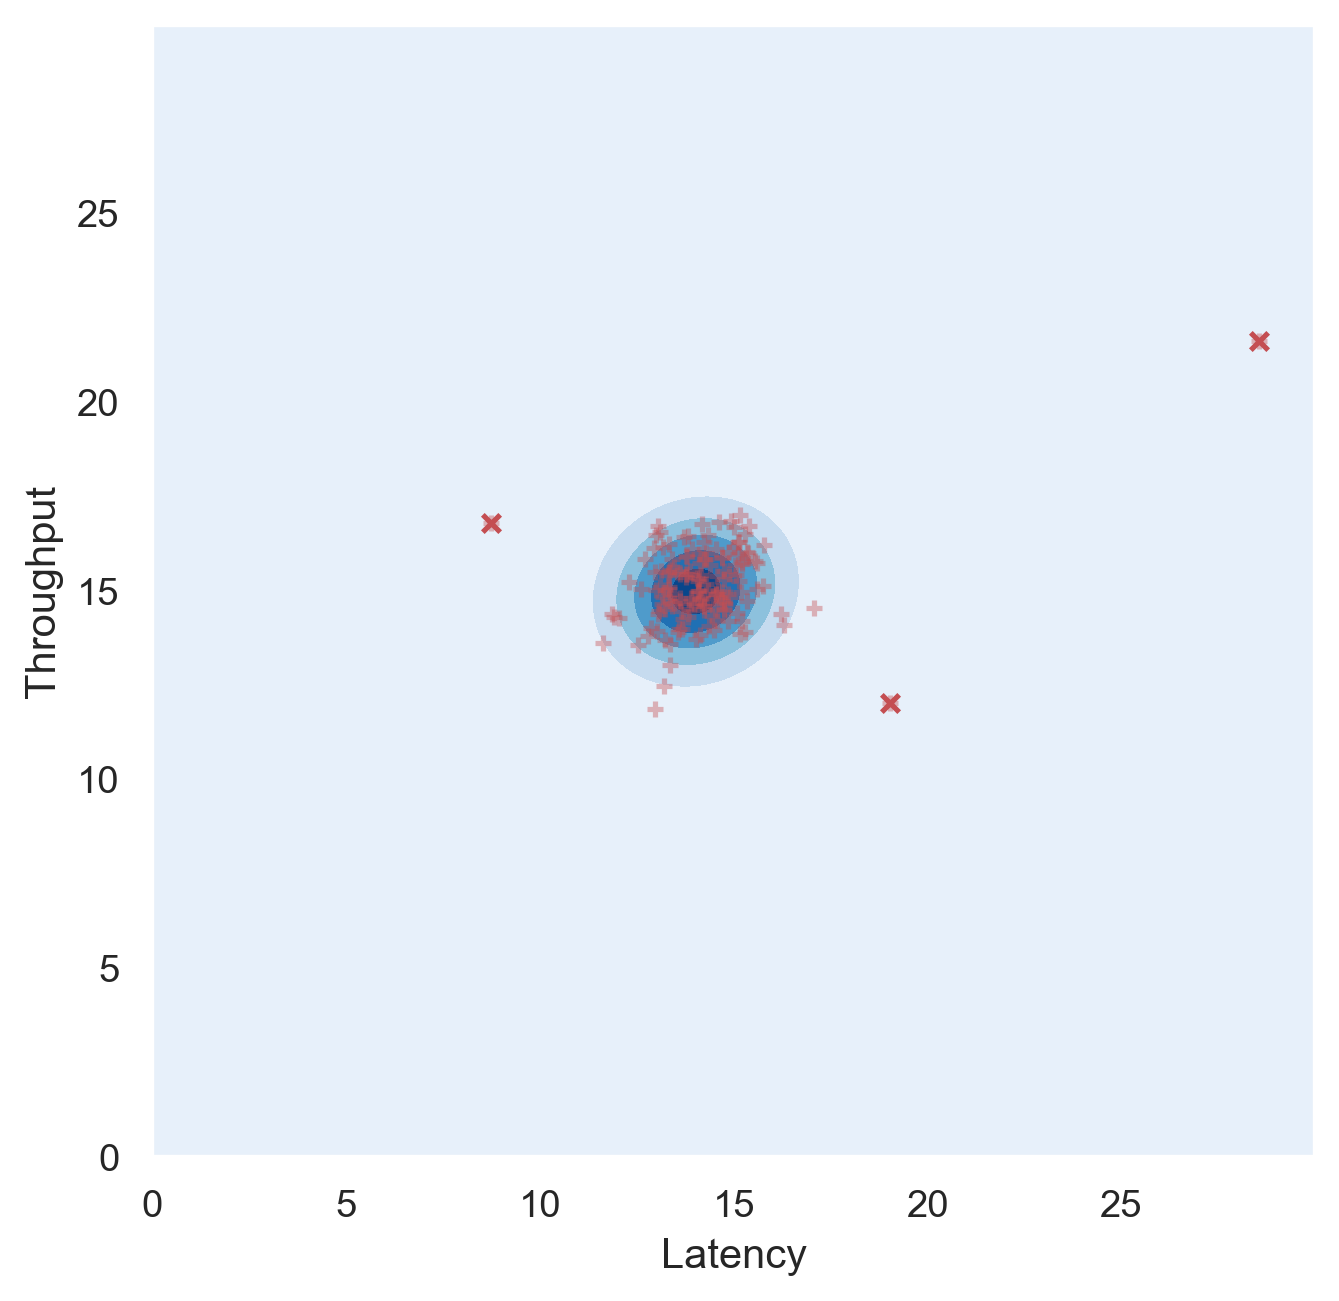

In [28]:
# construct test DataFrame
data = pd.DataFrame(Xtest, columns=['Latency', 'Throughput'])
data['y_pred'] = y_pred

# create a grid for graphing
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=250)

# plot probability density
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')

# plot original Xval points
sns.regplot('Latency', 'Throughput',
            data=data,
            fit_reg=False,
            ax=ax,
            scatter_kws={"s":20,
                         "alpha":0.4},marker='+',color='r')

# mark the predicted anamoly of CV data. We should have a test set for this...
anamoly_data = data[data['y_pred']==1]
ax.scatter(anamoly_data['Latency'], anamoly_data['Throughput'], marker='x', s=25, color='r')
plt.show()

## High dimensional dataset

In [29]:
data2 = load_mat('./data/ex8data2.mat')
data2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [30]:
X2 = data2.get('X')
Xval2, Xtest2, yval2, ytest2 = train_test_split(data2.get('Xval'),
                                            data2.get('yval').ravel(),
                                            test_size=0.5)

In [31]:
e2, fs2 = selectThreshold(X2, Xval2, yval2)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 3.6030764824313595e-05
Best F-score on validation data: 0.888888888888889


In [32]:
multi_normal2, y_pred2 = predict(X2, Xval2, e2, Xtest2, ytest2)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        44
           1       1.00      0.67      0.80         6

    accuracy                           0.96        50
   macro avg       0.98      0.83      0.89        50
weighted avg       0.96      0.96      0.96        50



In [33]:
print('find {} anamolies'.format(y_pred2.sum()))

find 4 anamolies


# Recommender systems
## Movie ratings dataset and moviesParams
- This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u$ = 943 users, and $n_m$ = 1682 movies. The matrix $Y$ (a $\text{num}_{\text{movies}} \times \text{num}_{\text{users}}$ matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix $R$ is an binary-valued indicator matrix, where $R^{(i, j)} = 1$ if user $j$ gave a rating to movie $i$, and $R^{(i, j)}=0$ otherwise.
- The $i$-th row of X corresponds to the feature vector $x^{(i)}$ for the i-th movie, and the $j$-th row of Theta corresponds to one parameter vector $\theta^{(j)}$, for the $j$-th user. Both x(i) and (j) are n-dimensional vectors. For the purposes of this exercise, you will use $n = 100$, and therefore, $x^{(i)}\in \mathbb{R}^{100}$ and $\theta{(j)}\in \mathbb{R}^{100}$. Correspondingly, X is a $n_m\times 100$ matrix and Theta is a $n_u \times 100$ matrix.

In [34]:
moviesData = load_mat('./data/ex8_movies.mat')
moviesData.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [35]:
Y = moviesData.get('Y')
Y.shape, Y

((1682, 943), array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))

In [36]:
R = moviesData.get('R')
R.shape, R.sum()

((1682, 943), 100000)

In [37]:
moviesParams = load_mat('./data/ex8_movieParams')
moviesParams.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [38]:
X = moviesParams.get('X')
Theta = moviesParams.get('Theta')
X.shape, Theta.shape

((1682, 10), (943, 10))

## Collaborative filtering cost function

$$J(x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_u)})= \frac{1}{2}\sum\limits_{(i,j):r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})^2$$

In [40]:
def serialize(X, theta):
    """serialize 2 matrix
    """
    # X (movie, feature), (1682, 10): movie features
    # theta (user, feature), (943, 10): user preference
    return np.concatenate((X.ravel(), theta.ravel()))


def deserialize(param, n_movie, n_user, n_features):
    """into ndarray of X(1682, 10), theta(943, 10)"""
    return param[:n_movie * n_features].reshape(n_movie, n_features), \
           param[n_movie * n_features:].reshape(n_user, n_features)


# recommendation fn
def cost(param, Y, R, n_features):
    """compute cost for every r(i, j)=1
    Args:
        param: serialized X, theta
        Y (movie, user), (1682, 943): (movie, user) rating
        R (movie, user), (1682, 943): (movie, user) has rating
    """
    # theta (user, feature), (943, 10): user preference
    # X (movie, feature), (1682, 10): movie features
    n_movie, n_user = Y.shape
    X, theta = deserialize(param, n_movie, n_user, n_features)

    inner = np.multiply(X @ theta.T - Y, R)

    return np.power(inner, 2).sum() / 2


def gradient(param, Y, R, n_features):
    # theta (user, feature), (943, 10): user preference
    # X (movie, feature), (1682, 10): movie features
    n_movies, n_user = Y.shape
    X, theta = deserialize(param, n_movies, n_user, n_features)

    inner = np.multiply(X @ theta.T - Y, R)  # (1682, 943)

    # X_grad (1682, 10)
    X_grad = inner @ theta

    # theta_grad (943, 10)
    theta_grad = inner.T @ X

    # roll them together and return
    return serialize(X_grad, theta_grad)


def regularized_cost(param, Y, R, n_features, l=1):
    reg_term = np.power(param, 2).sum() * (l / 2)

    return cost(param, Y, R, n_features) + reg_term


def regularized_gradient(param, Y, R, n_features, l=1):
    grad = gradient(param, Y, R, n_features)
    reg_term = l * param

    return grad + reg_term

In [41]:
# use subset of data to calculate the cost as in pdf...
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
theta_sub = Theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

param_sub = serialize(X_sub, theta_sub)
cost(param_sub, Y_sub, R_sub, features)

22.224603725685675

In [42]:
param = serialize(X, Theta)  # total real params

cost(serialize(X, Theta), Y, R, 10)  # this is real total cost

27918.64012454421

In [43]:
n_movie, n_user = Y.shape

X_grad, theta_grad = deserialize(gradient(param, Y, R, 10),
                                      n_movie, n_user, 10)

In [44]:
assert X_grad.shape == X.shape
assert theta_grad.shape == Theta.shape

In [45]:
# in the ex8_confi.m, lambda = 1.5, and it's using sub data set
regularized_cost(param_sub, Y_sub, R_sub, features, l=1.5)

31.34405624427422

In [46]:
movie_list = []

with open('./data/movie_ids.txt', encoding='latin-1') as f:
    for line in f:
        tokens = line.strip().split(' ')
        movie_list.append(' '.join(tokens[1:]))

movie_list = np.array(movie_list)

In [47]:
ratings = np.zeros(1682)

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

In [48]:
Y, R = moviesData.get('Y'), moviesData.get('R')


Y = np.insert(Y, 0, ratings, axis=1)  # now I become user 0
Y.shape

(1682, 944)

In [49]:
R = np.insert(R, 0, ratings != 0, axis=1)
R.shape

(1682, 944)

In [50]:
n_features = 50
n_movie, n_user = Y.shape
l = 10

In [51]:
X = np.random.standard_normal((n_movie, n_features))
theta = np.random.standard_normal((n_user, n_features))

X.shape, theta.shape

((1682, 50), (944, 50))

In [52]:
param = serialize(X, theta)

# normalized_ratings

In [53]:
Y_norm = Y - Y.mean()
Y_norm.mean()

4.6862111343939375e-17

## Training

In [54]:
import scipy.optimize as opt

In [55]:
res = opt.minimize(fun=regularized_cost,
                   x0=param,
                   args=(Y_norm, R, n_features, l),
                   method='TNC',
                   jac=regularized_gradient)
# very slow

In [56]:
res

     fun: 64721.497815075665
     jac: array([ 8.39460301e-08,  6.11067224e-07, -1.55260356e-06, ...,
        7.33711488e-07, -8.53449548e-07,  5.88929674e-08])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 2321
     nit: 72
  status: 1
 success: True
       x: array([ 0.26394484,  0.22910029, -0.17590401, ..., -0.21643881,
       -0.42017015,  0.04594261])

In [57]:
X_trained, theta_trained = deserialize(res.x, n_movie, n_user, n_features)
X_trained.shape, theta_trained.shape

((1682, 50), (944, 50))

In [58]:
prediction = X_trained @ theta_trained.T

In [59]:
my_preds = prediction[:, 0] + Y.mean()

In [60]:
idx = np.argsort(my_preds)[::-1]  # Descending order
idx.shape

(1682,)

In [61]:
# top ten idx
my_preds[idx][:10]

array([4.12534309, 4.0441487 , 3.99324747, 3.91902874, 3.81691704,
       3.8155616 , 3.76602577, 3.7632337 , 3.7590546 , 3.75076657])

In [62]:
for m in movie_list[idx][:10]:
    print(m)

Titanic (1997)
Star Wars (1977)
Shawshank Redemption, The (1994)
Forrest Gump (1994)
Raiders of the Lost Ark (1981)
Braveheart (1995)
Return of the Jedi (1983)
Usual Suspects, The (1995)
Godfather, The (1972)
Schindler's List (1993)
